In [8]:
import sys
import math
import re
from datetime import datetime
from pathlib import Path
from joblib import Parallel, delayed

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(str(Path("..").resolve()))
from hyper_rbm import load_model
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction

models_dir = Path("models")
state_dir = Path("state_vectors")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")
print(f"Looking for models in: {models_dir}")
print(f"Looking for GT state vectors in: {state_dir}")

Running on: cpu
Looking for models in: models
Looking for GT state vectors in: state_vectors


In [9]:
def estimate_susceptibility(model, h_val, n_samples, k_steps, rng):
    dtype = next(model.parameters()).dtype

    with torch.no_grad():
        cond_batch_gen = torch.full((n_samples, 1), h_val, device=device, dtype=dtype)
        schedule_tensor = torch.tensor([1.0] * k_steps, device=device, dtype=dtype)
        samples = model.generate(cond_batch_gen, T_schedule=schedule_tensor, rng=rng)

    cond_batch_grad = torch.full((n_samples, 1), h_val, device=device, dtype=dtype, requires_grad=True)

    log_psi = model.log_score(samples, cond_batch_grad)

    grads = torch.autograd.grad(outputs=log_psi, inputs=cond_batch_grad,
                                grad_outputs=torch.ones_like(log_psi), create_graph=False)[0]

    chi = torch.var(grads.squeeze(), unbiased=True)
    return chi.item()


def evaluate_model_file(model_path: Path):
    K_STEPS = 20
    TOTAL_SAMPLES = 5_000

    H_MIN = 1.0
    H_MAX = 4.5
    SWEEP_POINTS = 50

    print(f"Processing: {model_path.name}")

    model, config = load_model(model_path, device)

    match = re.search(r"seed(\d+)", model_path.name)
    seed_idx = int(match.group(1)) if match else 0

    SIDE_LENGTH = int(math.sqrt(model.num_v))

    h_eval = np.linspace(H_MIN, H_MAX, SWEEP_POINTS)

    results_list = []
    for h_val in h_eval:
        rng_point = torch.Generator(device=device).manual_seed(seed_idx)

        chi = estimate_susceptibility(model=model, h_val=float(h_val), n_samples=TOTAL_SAMPLES,
                                      k_steps=K_STEPS, rng=rng_point)

        results_list.append({"h": float(h_val), "chi_F": float(chi), "seed": seed_idx})

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df = pd.DataFrame(results_list)

    save_filename = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_suscept_rbm_seed{seed_idx}_{timestamp}.csv"
    results_df.to_csv(results_dir / save_filename, index=False, float_format="%.6e")

    return results_df

In [10]:
SIDE_LENGTH = 3
TARGET_SEEDS = {42, 43, 44, 45, 46, 47, 48, 49, 50, 51}

all_files = list(models_dir.glob(f"hyprbm_tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_20000_suscept_seed*.pt"))
parsed_files = []

for p in all_files:
    s_match = re.search(r"seed(\d+)", p.name)
    t_match = re.search(r"(\d{8}_\d{6})", p.name)

    if s_match and t_match:
        seed = int(s_match.group(1))
        ts = t_match.group(1)
        parsed_files.append({"seed": seed, "ts": ts, "path": p})

parsed_files.sort(key=lambda x: x["ts"], reverse=True)

selected_map = {}
for item in parsed_files:
    s = item["seed"]
    if s in TARGET_SEEDS and s not in selected_map:
        selected_map[s] = item["path"]

selected_paths = [selected_map[s] for s in sorted(selected_map.keys())]

print(f"Found {len(selected_map)} models overlapping with specified seed set (newest match only):")
for p in selected_paths:
    print(f"  - {p.name}")

Found 3 models overlapping with specified seed set (newest match only):
  - hyprbm_tfim_3x3_20000_suscept_seed42_20260206_035646.pt
  - hyprbm_tfim_3x3_20000_suscept_seed43_20260206_035652.pt
  - hyprbm_tfim_3x3_20000_suscept_seed44_20260206_035652.pt


In [11]:
results_list = Parallel(n_jobs=4)(delayed(evaluate_model_file)(p) for p in selected_paths)
all_results_df = pd.concat(results_list, ignore_index=True)
print("\nSusceptibility evaluation complete.")


Susceptibility evaluation complete.


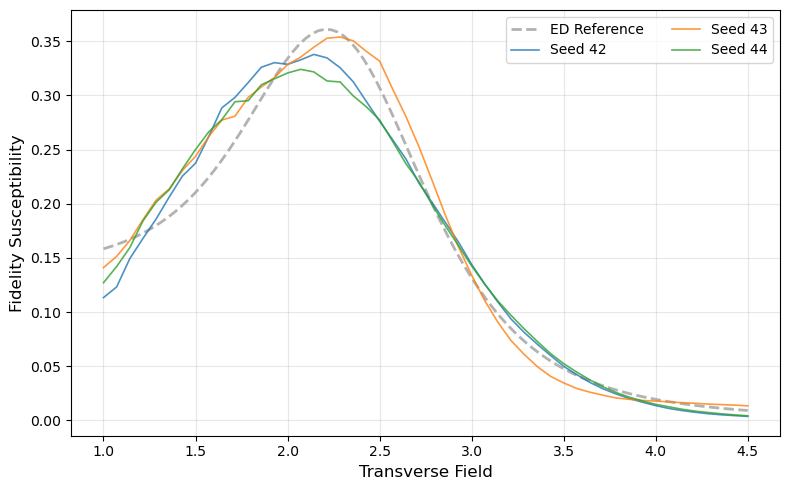

In [12]:
plot_df = all_results_df.copy()
h_vals = sorted(plot_df["h"].unique())
seeds = sorted(plot_df["seed"].unique())

ref_file = Path(f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_suscept_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None


def overlay_ed(ax):
    if ref_df is None or not {"h", "chi_F"}.issubset(ref_df.columns):
        return False

    ax.plot(ref_df["h"], ref_df["chi_F"], "--", color="gray",
            linewidth=2, alpha=0.6, zorder=0, label="ED Reference")
    return True


fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
cmap = plt.get_cmap("tab10")

overlay_ed(ax)

alpha_line = 0.80

for j, seed in enumerate(seeds):
    color = cmap(j % 10)
    sub = plot_df[plot_df["seed"] == seed].sort_values("h")
    if sub.empty:
        continue

    ax.plot(sub["h"], sub["chi_F"], "-", color=color, linewidth=1.2,
            alpha=alpha_line, zorder=5, label=f"Seed {seed}")

ax.set_xlabel(r"Transverse Field", fontsize=12)
ax.set_ylabel(r"Fidelity Susceptibility", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc="best", ncol=2)
fig.tight_layout()
plt.show()

In [13]:
def evaluate_model_file_overlap(model_path: Path):
    print(f"Processing overlap: {model_path.name}")

    model, config = load_model(model_path, device)

    match = re.search(r"seed(\d+)", model_path.name)
    seed_idx = int(match.group(1)) if match else 0

    SIDE_LENGTH = int(math.sqrt(model.num_v))
    h_support = config.get("h_support", [])

    if len(h_support) == 0:
        print(f"  - WARNING: no h_support in config for {model_path.name}")
        return pd.DataFrame(columns=["h", "overlap", "seed", "model_file"])

    all_states = generate_basis_states(model.num_v, device)

    rows = []
    for h_val in h_support:
        gt_path = state_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{float(h_val):.2f}.npz"
        if not gt_path.exists():
            raise FileNotFoundError(f"Missing GT wavefunction: {gt_path}")

        psi_true = load_gt_wavefunction(gt_path, device)
        overlap = calculate_exact_overlap(model, float(h_val), psi_true, all_states)

        rows.append({"h": float(h_val), "overlap": float(overlap), "seed": seed_idx})

        print(f"  h={float(h_val):.2f} | overlap={float(overlap):.6f}")

    overlap_df = pd.DataFrame(rows).sort_values("h").reset_index(drop=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_filename = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_overlap_rbm_seed{seed_idx}_{timestamp}.csv"
    overlap_df.to_csv(results_dir / save_filename, index=False, float_format="%.6e")

    return overlap_df

In [14]:
# run overlap eval on the SAME selected_paths we already built for susceptibility

overlap_results_list = Parallel(n_jobs=4)(
    delayed(evaluate_model_file_overlap)(p) for p in selected_paths
)

all_overlap_df = pd.concat(overlap_results_list, ignore_index=True)
print("\nOverlap evaluation complete.")


Overlap evaluation complete.


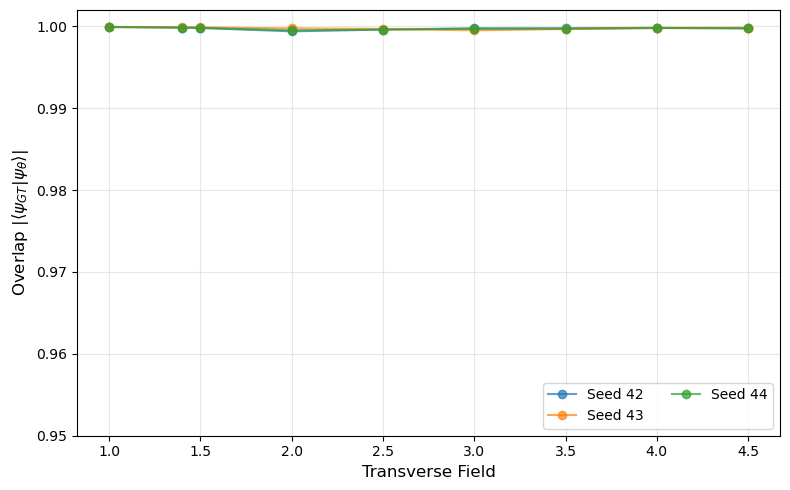

In [15]:
plt.figure(figsize=(8, 5), dpi=100)

unique_seeds = sorted(all_overlap_df["seed"].unique())
cmap = plt.get_cmap("tab10")

for i, seed in enumerate(unique_seeds):
    df = all_overlap_df[all_overlap_df["seed"] == seed].sort_values("h")
    if df.empty:
        continue

    c = cmap(i % 10)

    plt.plot(df["h"], df["overlap"], "-o", color=c, alpha=0.7, markersize=6, label=f"Seed {seed}")

plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_{GT} | \psi_{\theta} \rangle|$", fontsize=12)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right", ncol=2)
plt.tight_layout()
plt.show()